## import dependency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Input, Dense,MaxPooling2D, Flatten,Conv2D
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)    
    

In [4]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

## collecting negative data

In [16]:
import os

# Define the path to the directory where you want to move the files
NEG_PATH = 'data/negative'

# Ensure the NEG_PATH directory exists
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)

# Iterate over the directories and files in the 'lfw' directory
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    if os.path.isdir(dir_path):  # Check if it is indeed a directory
        for file in os.listdir(dir_path):
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)

            # Print paths to debug
            print(f'Moving {EX_PATH} to {NEW_PATH}')

            os.replace(EX_PATH, NEW_PATH)


Moving lfw\Aaron_Eckhart\Aaron_Eckhart_0001.jpg to data/negative\Aaron_Eckhart_0001.jpg
Moving lfw\Aaron_Guiel\Aaron_Guiel_0001.jpg to data/negative\Aaron_Guiel_0001.jpg
Moving lfw\Aaron_Patterson\Aaron_Patterson_0001.jpg to data/negative\Aaron_Patterson_0001.jpg
Moving lfw\Aaron_Peirsol\Aaron_Peirsol_0001.jpg to data/negative\Aaron_Peirsol_0001.jpg
Moving lfw\Aaron_Peirsol\Aaron_Peirsol_0002.jpg to data/negative\Aaron_Peirsol_0002.jpg
Moving lfw\Aaron_Peirsol\Aaron_Peirsol_0003.jpg to data/negative\Aaron_Peirsol_0003.jpg
Moving lfw\Aaron_Peirsol\Aaron_Peirsol_0004.jpg to data/negative\Aaron_Peirsol_0004.jpg
Moving lfw\Aaron_Pena\Aaron_Pena_0001.jpg to data/negative\Aaron_Pena_0001.jpg
Moving lfw\Aaron_Sorkin\Aaron_Sorkin_0001.jpg to data/negative\Aaron_Sorkin_0001.jpg
Moving lfw\Aaron_Sorkin\Aaron_Sorkin_0002.jpg to data/negative\Aaron_Sorkin_0002.jpg
Moving lfw\Aaron_Tippin\Aaron_Tippin_0001.jpg to data/negative\Aaron_Tippin_0001.jpg
Moving lfw\Abbas_Kiarostami\Abbas_Kiarostami_0001.

## collecting positive and anchore data

In [6]:
import uuid

In [12]:
import cv2

# Initialize the video capture object with the correct device index
cap = cv2.VideoCapture(0)  # Try different indices if necessary (0, 1, 2, etc.)

if not cap.isOpened():
    print("Error: Could not open video device.")
else:
    print("Video device opened successfully.")
    while cap.isOpened():
        ret, frame = cap.read()
        frame=frame[120:120+250,200:200+250,:]
        ## collecting anchore
        if cv2.waitKey(1) & 0xFF == ord('a'):
            imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        ## collecting positive
        if cv2.waitKey(1) & 0xFF == ord('p'):
            imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        if not ret:
            print("Error: Failed to capture image.")
            break
        # Check if the frame is empty
        if frame is None or frame.size == 0:
            continue
        cv2.imshow('Image Collection', frame)
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


Video device opened successfully.


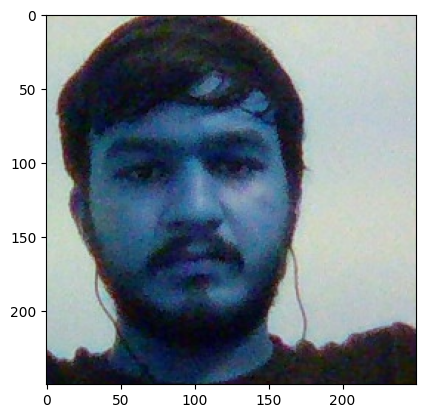

In [13]:
plt.imshow(frame[:,:,:])

In [99]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [100]:
dir_test = anchor.as_numpy_iterator()

In [101]:
print(dir_test.next())

b'data\\anchor\\ab81c0fd-37bb-11ef-b8b2-fc349794977f.jpg'


In [102]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [104]:
img=preprocess('data\\anchor\\ab81c0fd-37bb-11ef-b8b2-fc349794977f.jpg')

In [105]:
img.numpy().max()

0.8933824

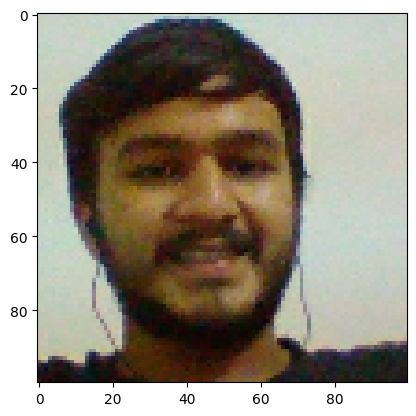

In [69]:
plt.imshow(img)

In [70]:
# (anchore , positive ) => 1,1,1,1,1
# (anchore , negative )=> 0,0,0,0,0

In [106]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [107]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\b560967d-37bb-11ef-aa05-fc349794977f.jpg',
 b'data\\positive\\c935558c-37bb-11ef-99f0-fc349794977f.jpg',
 1.0)

In [108]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

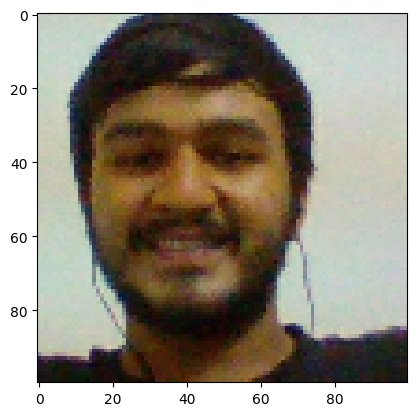

In [117]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [118]:
res[2]

1.0